Template loaded: ['template\\1000 (lama).jpg', 'template\\1000(baru).jpg', 'template\\10000.jpg', 'template\\2000.jpg', 'template\\50000.jpg']
Processing test image: test/2k.jpg


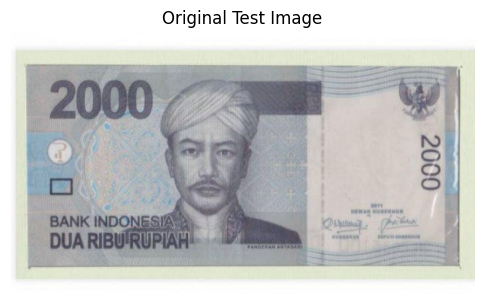

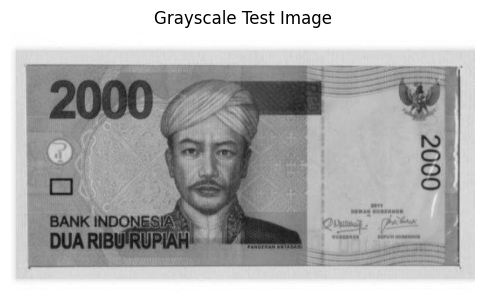

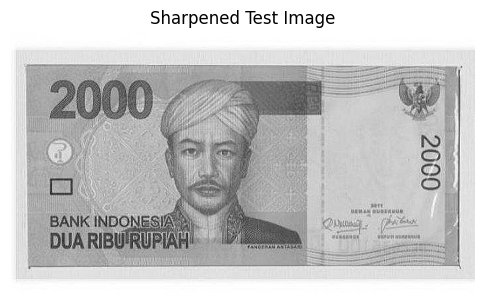

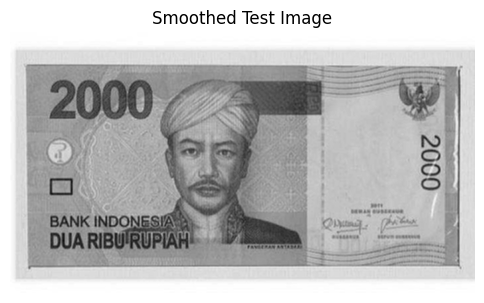

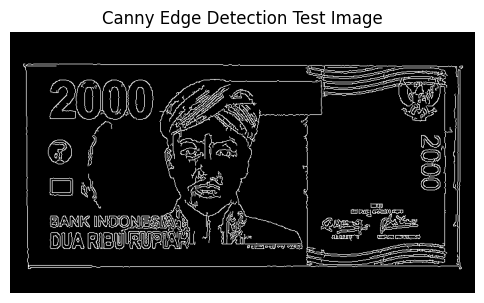

Uang: 2000 rupiah terdeteksi!


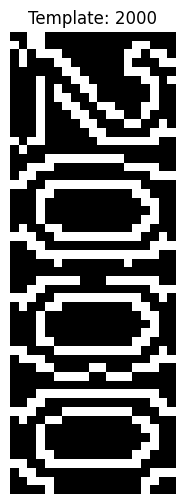

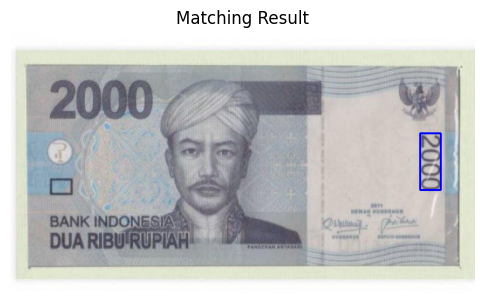

In [3]:
import glob
import cv2
import numpy as np
import imutils
import matplotlib.pyplot as plt
import pyttsx3
from gtts import gTTS
import os

def speak_text(text):
    # Buat file audio dari teks menggunakan bahasa Indonesia
    tts = gTTS(text=text, lang='id')
    tts.save("output.mp3")  # Simpan suara ke file MP3

    # Putar file audio
    os.system("start output.mp3")  # Windows

def display_image(title, img, cmap="gray"):
    """Helper function to display images using Matplotlib."""
    plt.figure(figsize=(6, 6))
    plt.imshow(img, cmap=cmap)
    plt.title(title)
    plt.axis("off")
    plt.show()


def uang_matching():
    # Load template
    template_data = []
    template_files = glob.glob('template/*.jpg', recursive=True)
    print("Template loaded:", template_files)

    # Prepare template
    for template_file in template_files:
        tmp = cv2.imread(template_file)
        if tmp is None:
            print(f"Failed to load template: {template_file}")
            continue
        tmp = imutils.resize(tmp, width=int(tmp.shape[1] * 0.5))  # Scaling
        tmp = cv2.cvtColor(tmp, cv2.COLOR_BGR2GRAY)  # Grayscale
        kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
        tmp = cv2.filter2D(tmp, -1, kernel)  # Sharpening
        tmp = cv2.blur(tmp, (3, 3))  # Smoothing
        tmp = cv2.Canny(tmp, 50, 200)  # Edge with Canny
        nominal = template_file.replace('template\\', '').replace('.jpg', '')
        template_data.append({"glob": tmp, "nominal": nominal})

    # Template matching on test images
    for image_glob in glob.glob('test/2k.jpg'):  # Loop over all test images
        image_test = cv2.imread(image_glob)
        if image_test is None:
            print(f"Failed to load test image: {image_glob}")
            continue

        print(f"Processing test image: {image_glob}")
        
        # Display the original test image
        display_image("Original Test Image", image_test, cmap=None)

        # Preprocessing steps
        # Grayscale
        image_gray = cv2.cvtColor(image_test, cv2.COLOR_BGR2GRAY)
        display_image("Grayscale Test Image", image_gray)

        # Sharpening
        kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
        image_sharpen = cv2.filter2D(image_gray, -1, kernel)
        display_image("Sharpened Test Image", image_sharpen)

        # Smoothing
        image_smooth = cv2.blur(image_sharpen, (3, 3))
        display_image("Smoothed Test Image", image_smooth)

        # Edge detection
        image_canny = cv2.Canny(image_smooth, 50, 200)
        display_image("Canny Edge Detection Test Image", image_canny)

        found_match = False  # Track if any template matches
        for template in template_data:
            (tmp_height, tmp_width) = template['glob'].shape[:2]

            found = None
            threshold = 0.4
            for scale in np.linspace(0.2, 1.0, 20)[::-1]:
                # Scaling the test image
                resized = imutils.resize(
                    image_canny, width=int(image_canny.shape[1] * scale))
                r = image_canny.shape[1] / float(resized.shape[1])
                if resized.shape[0] < tmp_height or resized.shape[1] < tmp_width:
                    break

                # Template matching
                result = cv2.matchTemplate(resized, template['glob'], cv2.TM_CCOEFF_NORMED)
                (_, maxVal, _, maxLoc) = cv2.minMaxLoc(result)
                if found is None or maxVal > found[0]:
                    found = (maxVal, maxLoc, r)
                    if maxVal >= threshold:
                        print(f"Uang: {template['nominal']} rupiah terdeteksi!")
                        speak_text(f"Uang {template['nominal']} rupiah terdeteksi!")
                        found_match = True

            if found is not None:
                (maxVal, maxLoc, r) = found
                (startX, startY) = (int(maxLoc[0] * r), int(maxLoc[1] * r))
                (endX, endY) = (
                    int((maxLoc[0] + tmp_width) * r),
                    int((maxLoc[1] + tmp_height) * r),
                )
                if maxVal >= threshold:
                    cv2.rectangle(image_test, (startX, startY),
                                  (endX, endY), (0, 0, 255), 2)

        # Display the matching template
                    display_image(f"Template: {template['nominal']}", template['glob'])
        
        if found_match:
            # Display the result if any match was found
            display_image("Matching Result", image_test, cmap=None)
        else:
            print("No matching template found for this test image.")


if __name__ == "__main__":
    uang_matching()
